In [1]:
# for interactive plots:
# %matplotlib widget

# for static plots:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import xtrack as xt

## Import MAD-X sequence to Xsuite

In [3]:
env = xt.load('PIMM.seq')
line = env.pimms

In [4]:
# Choose bend model appropriate for small rings
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=5)

## Define reference particle

In [5]:
line.set_particle_ref('proton', kinetic_energy0=200e6)

## Inspect machine layout

In [6]:
# Compute survey
sv = line.survey()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


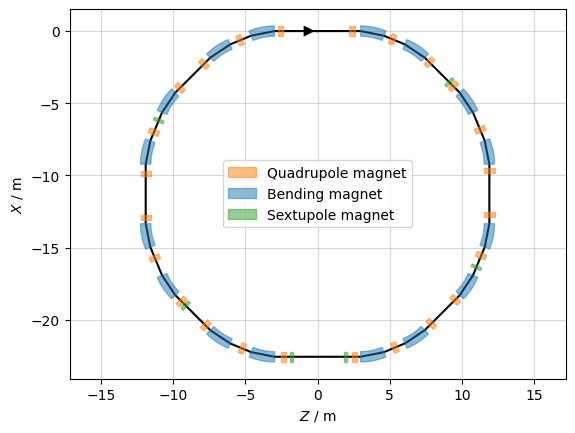

In [7]:
sv.plot()

### Table with machine elements

In [8]:
# To extract a table with all elements in the lattice
tt = line.get_table()

In [9]:
# Inspect first ten elements
tt.rows[:10].show()

name                     s element_type isthick isreplica parent_name iscollective       s_start ...
extr_septum              0 Marker         False     False None               False             0
||drift_1                0 Drift           True     False None               False             0
qfa.1               2.2125 Quadrupole      True     False None               False        2.2125
||drift_2           2.5625 Drift           True     False None               False        2.5625
mb::0                2.982 Bend            True     False None               False         2.982
||drift_3            4.643 Drift           True     False None               False         4.643
qd.1                5.1175 Quadrupole      True     False None               False        5.1175
||drift_4           5.4675 Drift           True     False None               False        5.4675
mb::1                6.217 Bend            True     False None               False         6.217
||drift_5::0         7.878

In [10]:
# Inspect all quadrupoles
ttquad = tt.rows[tt.element_type=='Quadrupole']
ttquad.show()

name              s element_type isthick isreplica parent_name iscollective       s_start ...
qfa.1        2.2125 Quadrupole      True     False None               False        2.2125
qd.1         5.1175 Quadrupole      True     False None               False        5.1175
qfa.2        8.1525 Quadrupole      True     False None               False        8.1525
qfb.1       10.5025 Quadrupole      True     False None               False       10.5025
qd.2        14.0875 Quadrupole      True     False None               False       14.0875
qfb.2       17.0225 Quadrupole      True     False None               False       17.0225
qfb.3       20.0725 Quadrupole      True     False None               False       20.0725
qd.3        23.0075 Quadrupole      True     False None               False       23.0075
qfb.4       26.5925 Quadrupole      True     False None               False       26.5925
qfa.3       28.9425 Quadrupole      True     False None               False       28.9425
qd.4  

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


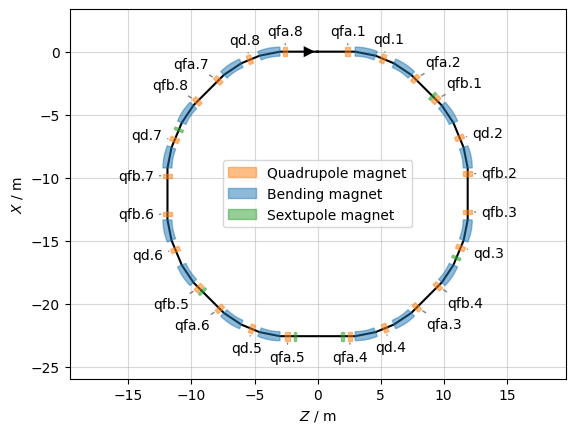

In [11]:
# Label all quadrupoles in survey plot to identify three quadrupole families
# (qfa, qfb, qd)
sv.plot(labels=ttquad.name)

### Inspect one element

In [12]:
line['qfa.1']

View of Quadrupole(k1=0, k1s=0, length=0.35, num_multipole_kicks=np.int64(5), order=np.int64(5), inv_factorial_order=0.00833, knl=[0., 0., 0., 0., 0., 0.], ksl=[0., 0., 0., 0., 0., 0.], edge_entry_active=np.uint64(0), edge_exit_active=np.uint64(0), model='adaptive', integrator='adaptive', radiation_flag=np.int64(0), delta_taper=0, shift_x=0, shift_y=0, shift_s=0, rot_s_rad=0, rot_x_rad=0, rot_y_rad=0, rot_s_rad_no_frame=0, rot_shift_anchor=0)

### Inspect knobs controlling a element

In [13]:
line.ref['qfa.2'].k1._expr

vars['kqfa']

### Get all elements controlled by one knob

In [14]:
line.ref['kqd']._info(limit=None)

#  vars['kqd']._get_value()
   vars['kqd'] = 0

#  vars['kqd']._expr is None

#  vars['kqd']._find_dependant_targets()
   element_refs['qd.8'].k1
   element_refs['qd.7'].k1
   element_refs['qd.6'].k1
   element_refs['qd.5'].k1
   element_refs['qd.4'].k1
   element_refs['qd.3'].k1
   element_refs['qd.2'].k1
   element_refs['qd.1'].k1
   element_refs['qd'].k1



# Match the optics

We start by controlling all focusing quadrupoles with the same strength:

In [15]:
line['kqf_common'] = 0
line['kqfa'] = 'kqf_common'
line['kqfb'] = 'kqf_common'


Put a small strength all quads to get a stable lattice:

In [16]:
line['kqf_common'] = 2e-2
line['kqd'] = -2e-2

First twiss:

In [17]:
tw0 = line.twiss(method='4d')

# Tunes
tw0.qx, tw0.qy

(np.float64(0.33043572515482267), np.float64(1.6932434815547222))

(0.0, 130.0)

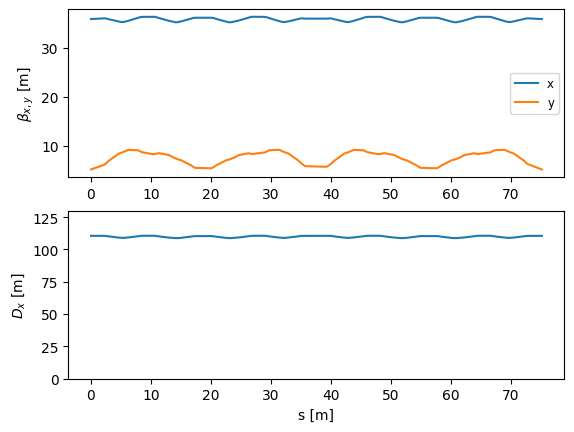

In [18]:
# Optics functions
plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw0.s, tw0.betx, '-', label='x')
plt.plot(tw0.s, tw0.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw0.s, tw0.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')
plt.ylim(bottom=0, top=130)

## Control the tunes

In [19]:
opt = line.match(
    solve=False, # <- prepare the match without running it
    method='4d',
    vary=[
        xt.Vary('kqf_common', limits=(0, 1),  step=1e-3),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3),
        
    ],
    targets=[
        xt.TargetSet(qx=1.663, qy=1.72, tol=1e-6, tag='tunes'),
    ]
)


In [20]:
# Inspect situation before the match
opt.target_status()
opt.vary_status()

Target status:               alty = 1.3328e+01              
id state tag   tol_met       residue   current_val    target_val description                                 
0  ON    tunes   False      -1.33256      0.330436         1.663 line=pimms, 'qx', val=1.663, tol=1e-06,  ...
1  ON    tunes   False    -0.0267565       1.69324          1.72 line=pimms, 'qy', val=1.72, tol=1e-06, w ...
Vary status:                 
id state tag met name       lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqf_common           0          0.02           1          0.02         0.001             1
1  ON        OK  kqd                 -1         -0.02           0         -0.02         0.001             1


In [21]:
# Perform ten optimization steps
opt.step(10)

                                             
Optimize - start penalty: 13.33                             
Matching: model call n. 19 penalty = 1.3894e-06              
Optimize - end penalty:  1.38944e-06                            


In [22]:
# Inspect optimization log
opt.log()

Table: 6 rows, 16 cols
iteration                   penalty alpha tag tol_met target_active hit_limits vary_active ...
0                           13.3283    -1     nn      yy            nn         yy         
1                           13.3283    -1     nn      yy            nn         yy         
2                           6.64891     1     nn      yy            nn         yy         
3                          0.676583     0     nn      yy            nn         yy         
4                         0.0129419     0     nn      yy            nn         yy         
5                       1.38944e-06     0     yy      yy            nn         yy         

In [23]:
# Inspect situation after the match
opt.target_status()
opt.vary_status()

Target status:               nalty = 1.3894e-06              
id state tag   tol_met       residue   current_val    target_val description                                 
0  ON    tunes    True  -1.30436e-08         1.663         1.663 line=pimms, 'qx', val=1.663, tol=1e-06,  ...
1  ON    tunes    True    1.3833e-07          1.72          1.72 line=pimms, 'qy', val=1.72, tol=1e-06, w ...
Vary status:                 
id state tag met name       lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqf_common           0      0.414416           1          0.02         0.001             1
1  ON        OK  kqd                 -1      -0.52692           0         -0.02         0.001             1


Text(0.5, 0, 's [m]')

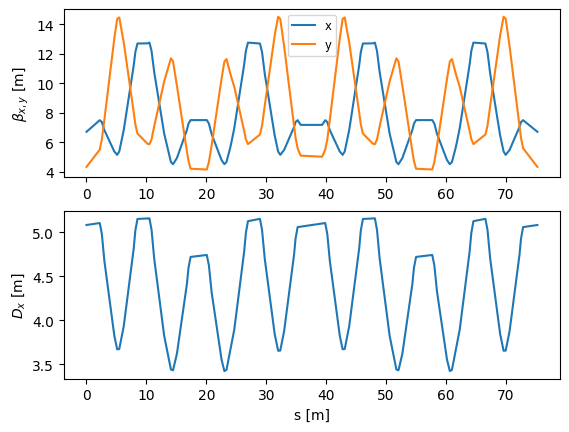

In [24]:
# Twiss again
tw = line.twiss(method='4d')

plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw.s, tw.betx, '-', label='x')
plt.plot(tw.s, tw.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw.s, tw.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')


### Impose zero dispersion at electrostatic septum

In [25]:
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['kqfa', 'kqfb'], limits=(0, 1),  step=1e-3),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3),        
    ],
    targets=[
        xt.TargetSet(qx=1.663, qy=1.72, tol=1e-6),
        xt.Target(dx = 0, at='extr_septum', tol=1e-6)
    ]
)

In [26]:
opt.target_status()
opt.step(20)

Target status:               alty = 5.0852e+01              
id state tag            tol_met       residue   current_val    target_val description                                 
0  ON    qx                True  -1.30436e-08         1.663         1.663 line=pimms, 'qx', val=1.663, tol=1e-06,  ...
1  ON    qy                True    1.3833e-07          1.72          1.72 line=pimms, 'qy', val=1.72, tol=1e-06, w ...
2  ON    extr_septum_dx   False       5.08518       5.08518             0 line=pimms, ('dx', 'extr_septum'), val=0 ...
                                             
Optimize - start penalty: 50.85                             
Matching: model call n. 22 penalty = 1.0239e-08              
Optimize - end penalty:  1.02387e-08                            


In [27]:
opt.target_status()
opt.vary_status()

Target status:               nalty = 1.0239e-08              
id state tag            tol_met       residue   current_val    target_val description                                 
0  ON    qx                True   1.04847e-10         1.663         1.663 line=pimms, 'qx', val=1.663, tol=1e-06,  ...
1  ON    qy                True  -1.02147e-11          1.72          1.72 line=pimms, 'qy', val=1.72, tol=1e-06, w ...
2  ON    extr_septum_dx    True   1.01843e-09   1.01843e-09             0 line=pimms, ('dx', 'extr_septum'), val=0 ...
Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqfa           0      0.311895           1      0.414416         0.001             1
1  ON        OK  kqfb           0      0.524803           1      0.414416         0.001             1
2  ON        OK  kqd           -1     -0.523847           0      -0.52692         0.001             1


Text(0.5, 0, 's [m]')

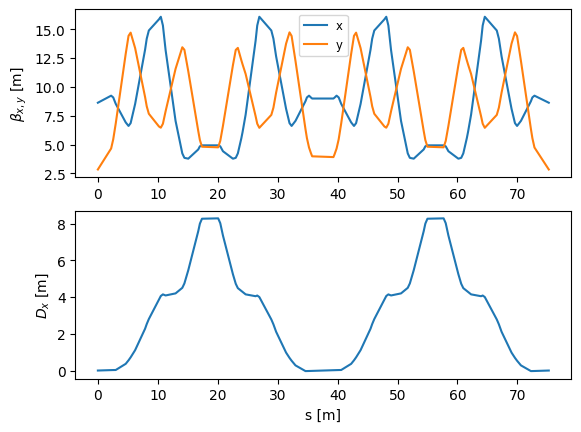

In [28]:
# Twiss again
tw = line.twiss(method='4d')

plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw.s, tw.betx, '-', label='x')
plt.plot(tw.s, tw.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw.s, tw.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')

## Correct chromaticity

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


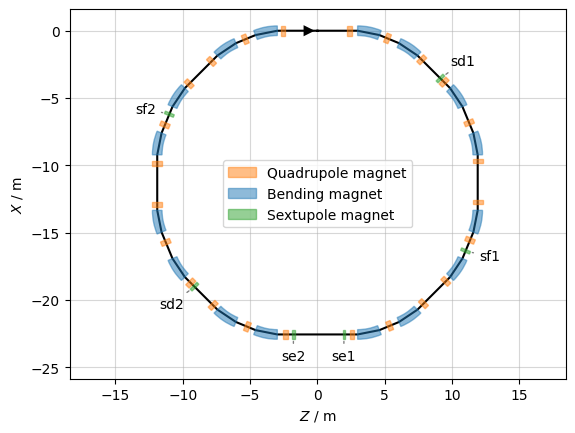

In [29]:
# Label all sextupoles (sf, sd and se)
ttsext = tt.rows[tt.element_type=='Sextupole']
sv.plot(labels=ttsext.name)

In [30]:
# We build a single match with all constraints
# (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['ksf', 'ksd'], step=1e-3),
        xt.VaryList(['kqfa', 'kqfb'], limits=(0, 1),  step=1e-3, tag='qf'),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3, tag='qd'),
    ],
    targets=[
        xt.TargetSet(dqx=-0.1, dqy=-0.1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='extr_septum', tol=1e-6),
        xt.TargetSet(qx=1.663, qy=1.72, tol=1e-6),
    ]
)
opt.step(20)

                                             
Optimize - start penalty: 1.741                             
Matching: model call n. 15 penalty = 5.0147e-07              
Optimize - end penalty:  5.0147e-07                            


In [31]:
opt.target_status()

Target status:               nalty = 5.0147e-07              
id state tag            tol_met       residue   current_val    target_val description                                 
0  ON    chrom             True   4.99968e-07    -0.0999995          -0.1 line=pimms, 'dqx', val=-0.1, tol=0.001,  ...
1  ON    chrom             True   1.99879e-08          -0.1          -0.1 line=pimms, 'dqy', val=-0.1, tol=0.001,  ...
2  ON    extr_septum_dx    True  -3.20315e-09  -3.20315e-09             0 line=pimms, ('dx', 'extr_septum'), val=0 ...
3  ON    qx                True   8.46911e-10         1.663         1.663 line=pimms, 'qx', val=1.663, tol=1e-06,  ...
4  ON    qy                True  -2.63092e-10          1.72          1.72 line=pimms, 'qy', val=1.72, tol=1e-06, w ...


In [32]:
opt.vary_status()

Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  ksf  None             -1.40245 None                    0         0.001             1
1  ON        OK  ksd  None             0.818263 None                    0         0.001             1
2  ON    qf  OK  kqfa 0                0.311967 1                0.311895         0.001             1
3  ON    qf  OK  kqfb 0                 0.52479 1                0.524803         0.001             1
4  ON    qd  OK  kqd  -1              -0.523934 0               -0.523847         0.001             1


### Insert septum aperture

In [33]:
line.discard_tracker()
line.insert_element(name='septum_aperture',
                    element=xt.LimitRect(min_x=-0.1, max_x=0.1, min_y=-0.1, max_y=0.1),
                    at='extr_septum')

### Save machine state

In [34]:
line.to_json('pimms_00_optics.json')